### Import libraries

In [1]:
import sys
sys.path.append("..")
from model import classic_model, combined_model, experimental_model, losses, grapher
from data import batch_creator, gp_kernels, gp_priors, loader
from helpers import helpers, plotter, masks
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
# options: rbf, periodic
kernel = input()
dataset_size = input()
save_dir = '/Users/omernivron/Downloads/GPT_' + kernel

periodic


In [3]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te = loader.load_data(kernel, size = dataset_size)

Directory is empty 
 Generating data..


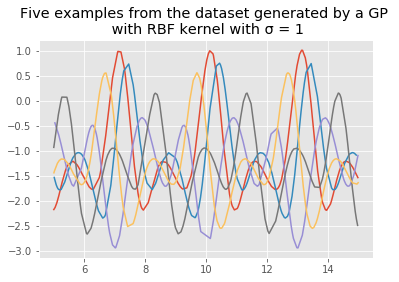

In [25]:
plotter.plot_examples(pad_pos_tr, pad_y_fren_tr)

In [68]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [69]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

New folder /Users/omernivron/Downloads/GPT_periodic/ckpt/check__run_5_heads_64_encoding_1024
Initializing from scratch.


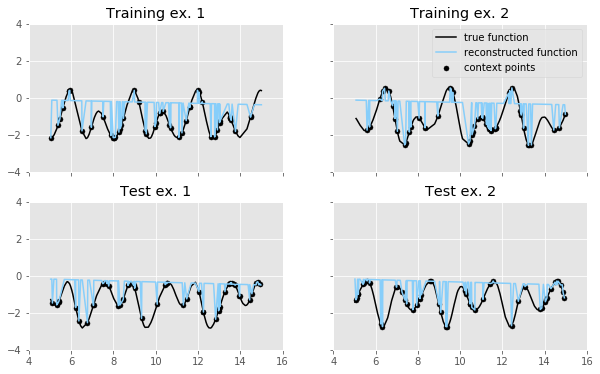

Epoch 0 batch 0 train Loss 2.3740 test Loss 1.3071 with training MSE metric 1.5919 and testing MSE metric 1.4304
learning rate is 9.999999747378752e-05


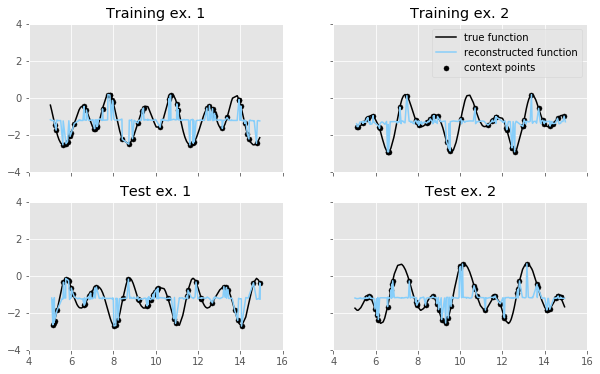

Epoch 0 batch 300 train Loss 0.3498 test Loss 0.8144 with training MSE metric 0.7121 and testing MSE metric 1.0485
learning rate is 9.999999747378752e-05


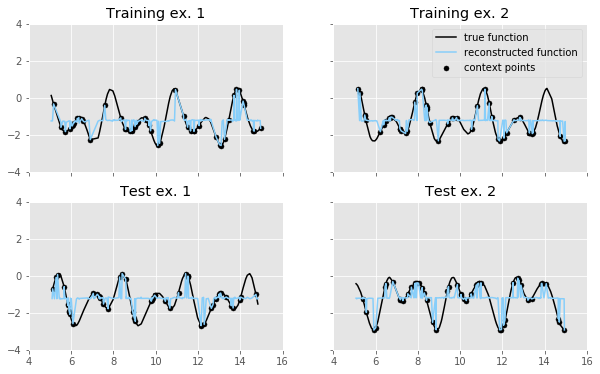

Epoch 0 batch 600 train Loss 0.3362 test Loss 0.6501 with training MSE metric 0.6904 and testing MSE metric 0.9209
learning rate is 9.999999747378752e-05


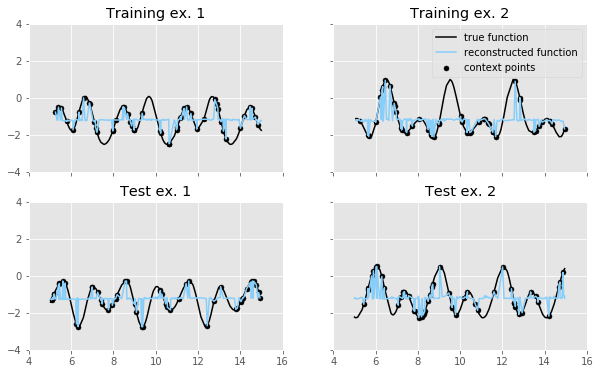

Epoch 0 batch 900 train Loss 0.3316 test Loss 0.5679 with training MSE metric 0.6829 and testing MSE metric 0.8570
learning rate is 9.999999747378752e-05


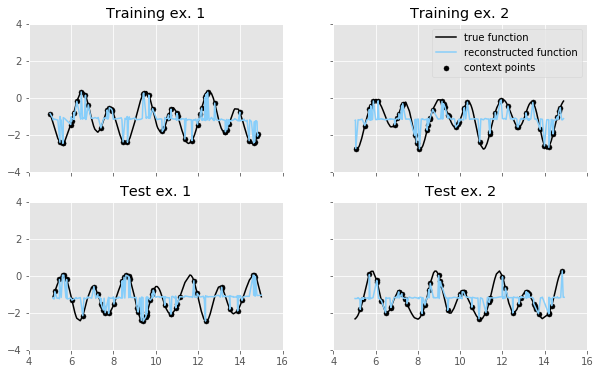

Epoch 0 batch 1200 train Loss 0.3291 test Loss 0.5184 with training MSE metric 0.6787 and testing MSE metric 0.8183
learning rate is 9.999999747378752e-05


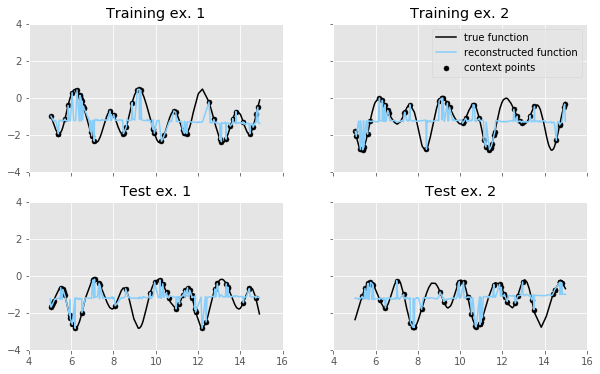

Epoch 0 batch 1500 train Loss 0.3275 test Loss 0.4853 with training MSE metric 0.6758 and testing MSE metric 0.7921
learning rate is 9.999999747378752e-05


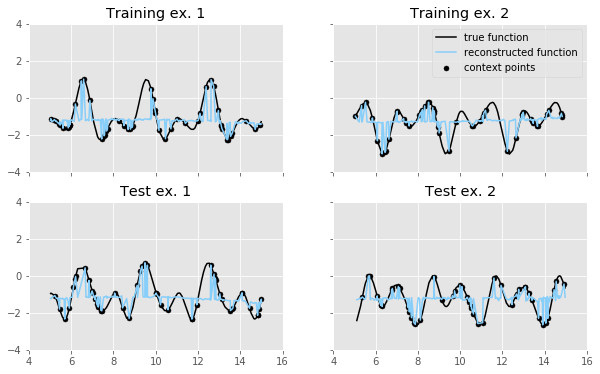

Epoch 0 batch 1800 train Loss 0.3262 test Loss 0.4616 with training MSE metric 0.6734 and testing MSE metric 0.7732
learning rate is 9.999999747378752e-05
Time taken for 1 epoch: 11264.30219912529 secs



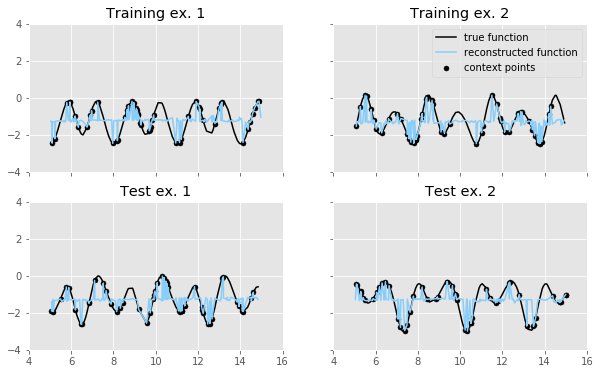

Epoch 1 batch 0 train Loss 0.3152 test Loss 0.3192 with training MSE metric 0.6490 and testing MSE metric 0.6597
learning rate is 9.999999747378752e-05


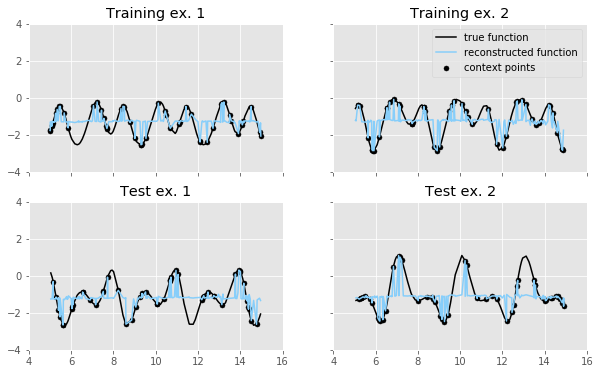

Epoch 1 batch 300 train Loss 0.3203 test Loss 0.3191 with training MSE metric 0.6624 and testing MSE metric 0.6596
learning rate is 9.999999747378752e-05


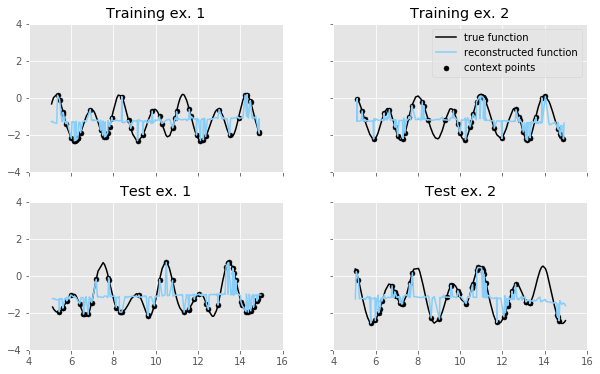

Epoch 1 batch 600 train Loss 0.3198 test Loss 0.3191 with training MSE metric 0.6610 and testing MSE metric 0.6594
learning rate is 9.999999747378752e-05


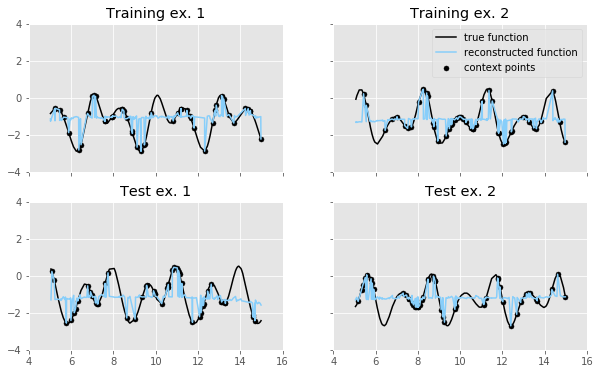

Epoch 1 batch 900 train Loss 0.3196 test Loss 0.3190 with training MSE metric 0.6607 and testing MSE metric 0.6591
learning rate is 9.999999747378752e-05


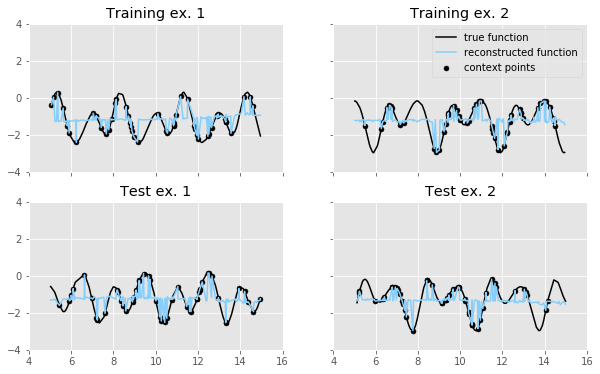

Epoch 1 batch 1200 train Loss 0.3197 test Loss 0.3189 with training MSE metric 0.6608 and testing MSE metric 0.6588
learning rate is 9.999999747378752e-05


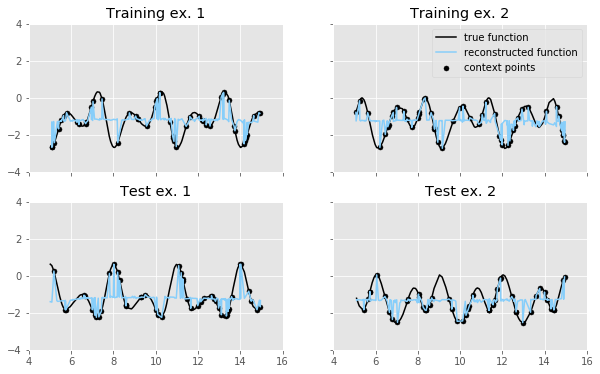

Epoch 1 batch 1500 train Loss 0.3196 test Loss 0.3188 with training MSE metric 0.6605 and testing MSE metric 0.6586
learning rate is 9.999999747378752e-05


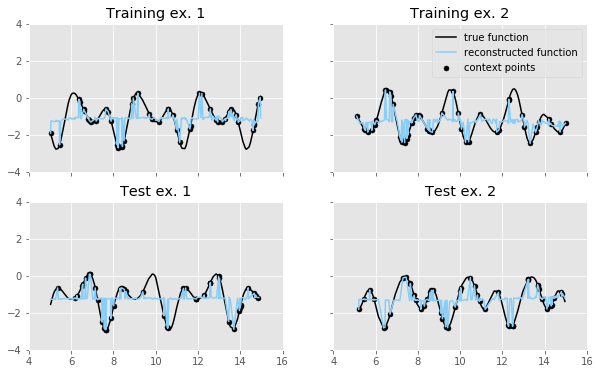

Epoch 1 batch 1800 train Loss 0.3194 test Loss 0.3187 with training MSE metric 0.6600 and testing MSE metric 0.6583
learning rate is 9.999999747378752e-05
Time taken for 1 epoch: 10411.695992946625 secs



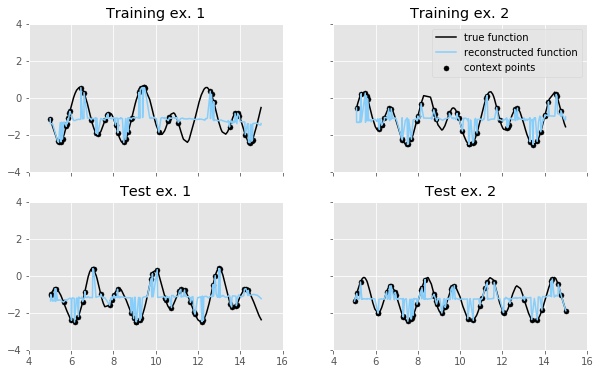

Epoch 2 batch 0 train Loss 0.3143 test Loss 0.3178 with training MSE metric 0.6467 and testing MSE metric 0.6562
learning rate is 9.999999747378752e-05


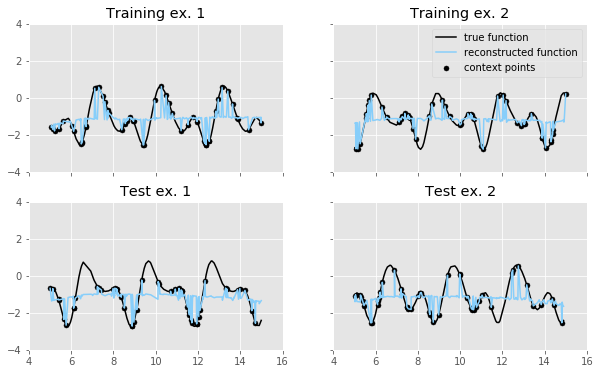

Epoch 2 batch 300 train Loss 0.3182 test Loss 0.3177 with training MSE metric 0.6570 and testing MSE metric 0.6559
learning rate is 9.999999747378752e-05


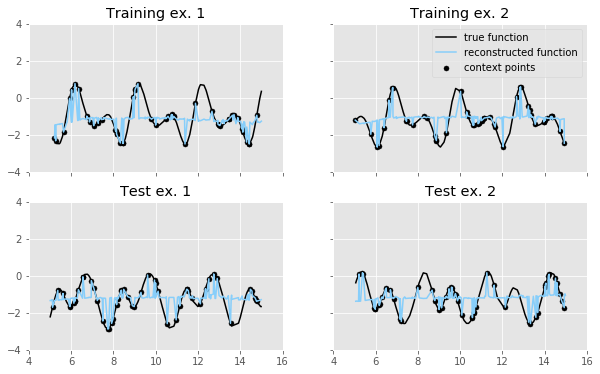

Epoch 2 batch 600 train Loss 0.3182 test Loss 0.3176 with training MSE metric 0.6571 and testing MSE metric 0.6556
learning rate is 9.999999747378752e-05


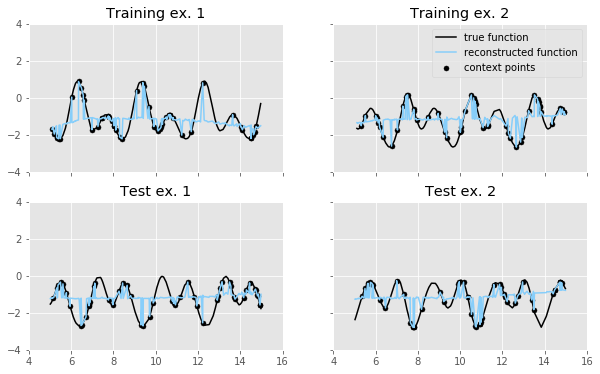

Epoch 2 batch 900 train Loss 0.3182 test Loss 0.3175 with training MSE metric 0.6569 and testing MSE metric 0.6554
learning rate is 9.999999747378752e-05


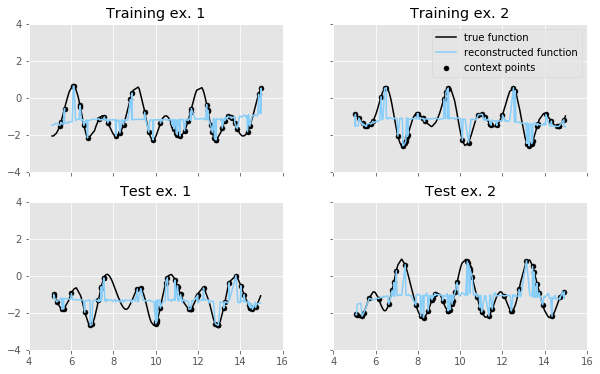

Epoch 2 batch 1200 train Loss 0.3180 test Loss 0.3174 with training MSE metric 0.6564 and testing MSE metric 0.6551
learning rate is 9.999999747378752e-05


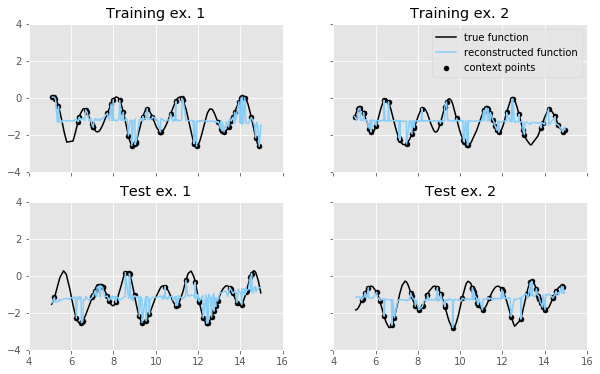

Epoch 2 batch 1500 train Loss 0.3179 test Loss 0.3172 with training MSE metric 0.6562 and testing MSE metric 0.6546
learning rate is 9.999999747378752e-05


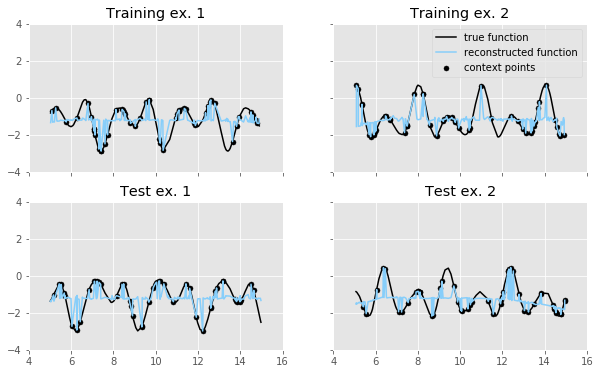

Epoch 2 batch 1800 train Loss 0.3177 test Loss 0.3170 with training MSE metric 0.6555 and testing MSE metric 0.6541
learning rate is 9.999999747378752e-05
Time taken for 1 epoch: 10198.425697088242 secs



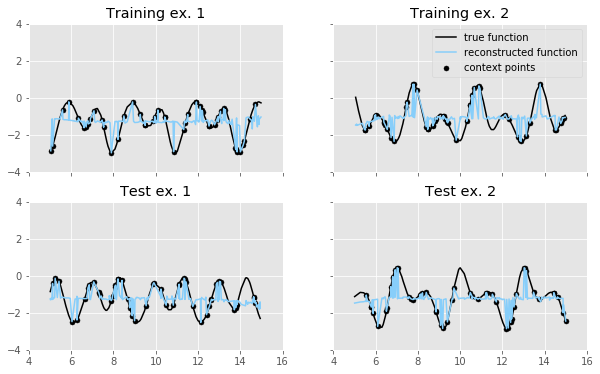

Epoch 3 batch 0 train Loss 0.3194 test Loss 0.3163 with training MSE metric 0.6597 and testing MSE metric 0.6510
learning rate is 9.999999747378752e-05


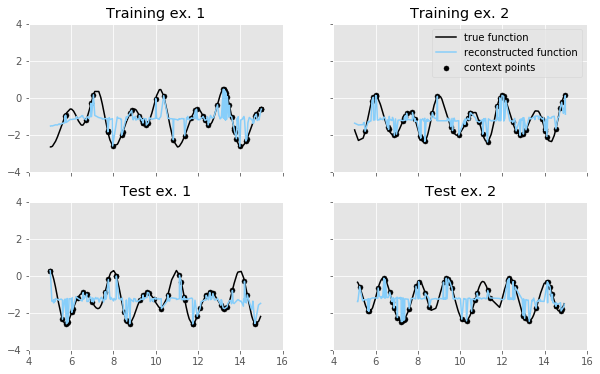

Epoch 3 batch 300 train Loss 0.3159 test Loss 0.3158 with training MSE metric 0.6507 and testing MSE metric 0.6502
learning rate is 9.999999747378752e-05


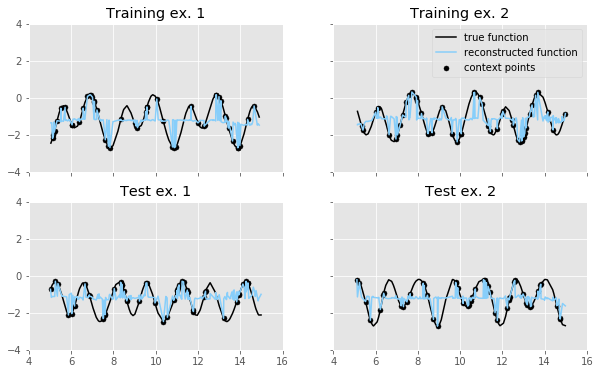

Epoch 3 batch 600 train Loss 0.3150 test Loss 0.3151 with training MSE metric 0.6484 and testing MSE metric 0.6483
learning rate is 9.999999747378752e-05


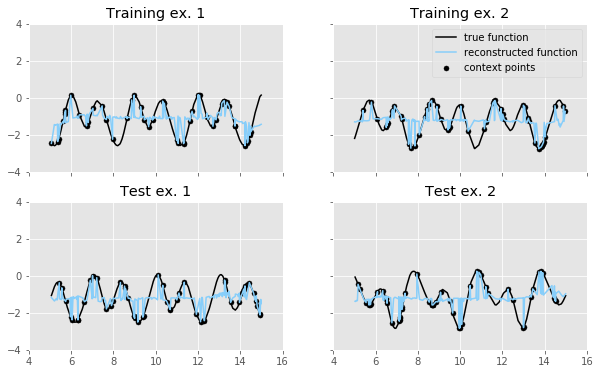

Epoch 3 batch 900 train Loss 0.3139 test Loss 0.3135 with training MSE metric 0.6457 and testing MSE metric 0.6444
learning rate is 9.999999747378752e-05


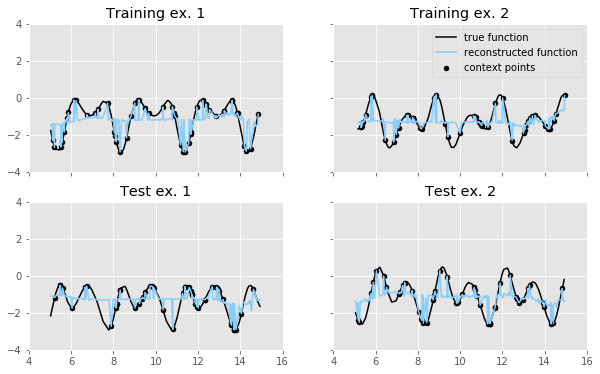

Epoch 3 batch 1200 train Loss 0.3126 test Loss 0.3119 with training MSE metric 0.6424 and testing MSE metric 0.6404
learning rate is 9.999999747378752e-05


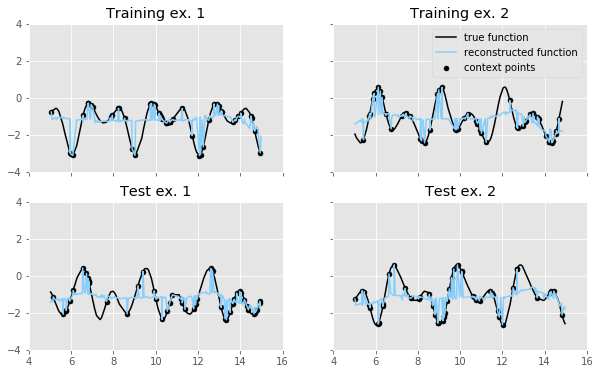

Epoch 3 batch 1500 train Loss 0.3112 test Loss 0.3102 with training MSE metric 0.6388 and testing MSE metric 0.6362
learning rate is 9.999999747378752e-05


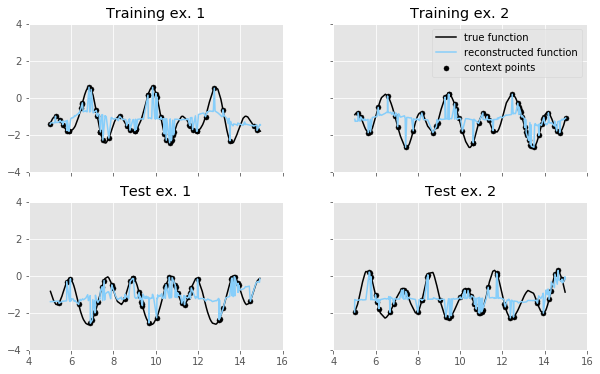

Epoch 3 batch 1800 train Loss 0.3096 test Loss 0.3085 with training MSE metric 0.6350 and testing MSE metric 0.6320
learning rate is 9.999999747378752e-05
Time taken for 1 epoch: 10219.496116161346 secs



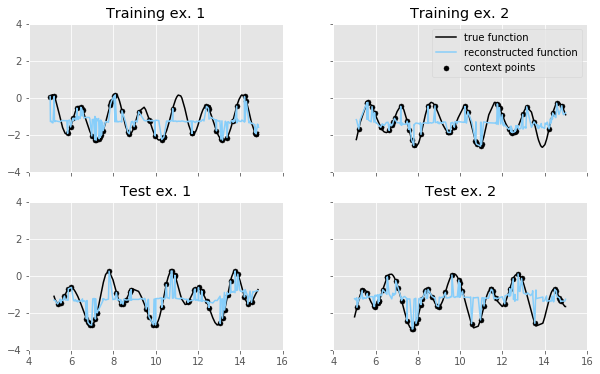

Epoch 4 batch 0 train Loss 0.2994 test Loss 0.2974 with training MSE metric 0.6087 and testing MSE metric 0.6046
learning rate is 9.999999747378752e-05


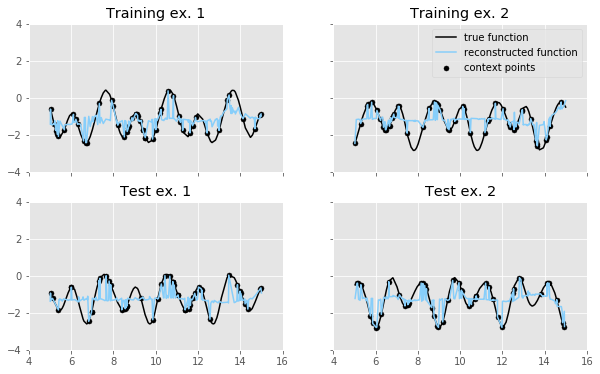

Epoch 4 batch 300 train Loss 0.2957 test Loss 0.2959 with training MSE metric 0.6006 and testing MSE metric 0.5998
learning rate is 9.999999747378752e-05


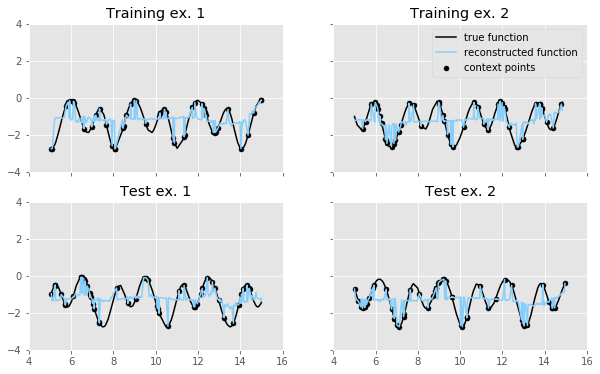

Epoch 4 batch 600 train Loss 0.2939 test Loss 0.2933 with training MSE metric 0.5962 and testing MSE metric 0.5942
learning rate is 9.999999747378752e-05


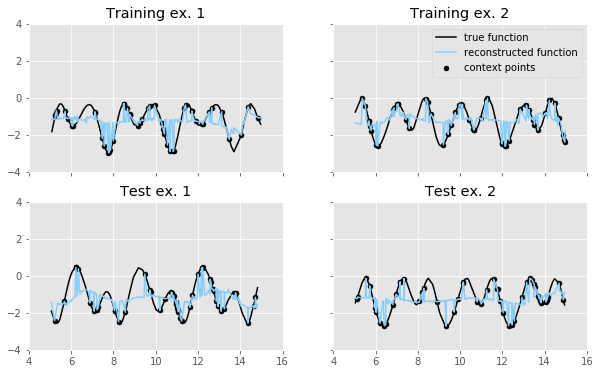

Epoch 4 batch 900 train Loss 0.2917 test Loss 0.2902 with training MSE metric 0.5911 and testing MSE metric 0.5872
learning rate is 9.999999747378752e-05


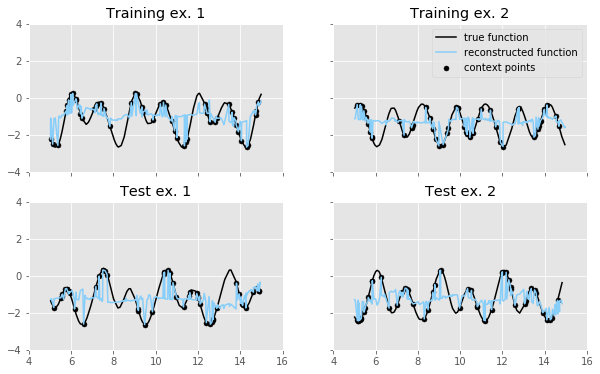

Epoch 4 batch 1200 train Loss 0.2891 test Loss 0.2874 with training MSE metric 0.5851 and testing MSE metric 0.5806
learning rate is 9.999999747378752e-05


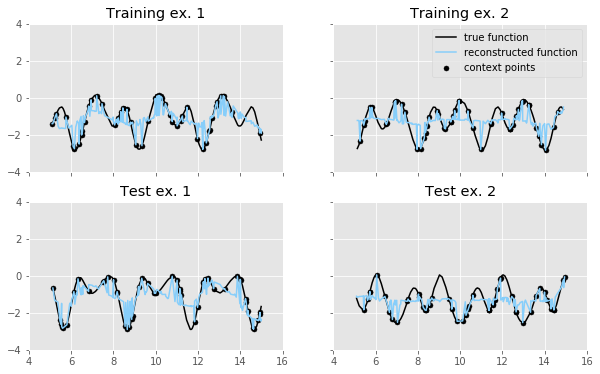

Epoch 4 batch 1500 train Loss 0.2865 test Loss 0.2841 with training MSE metric 0.5790 and testing MSE metric 0.5734
learning rate is 9.999999747378752e-05


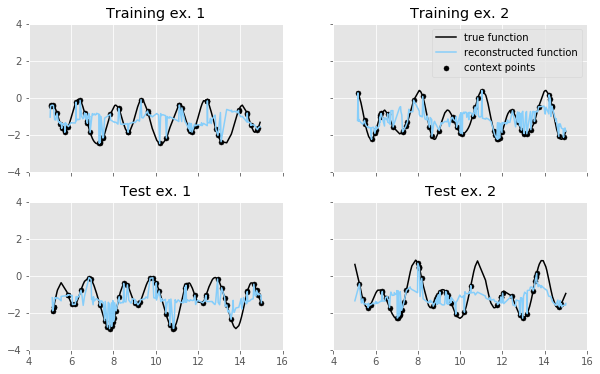

Epoch 4 batch 1800 train Loss 0.2838 test Loss 0.2814 with training MSE metric 0.5730 and testing MSE metric 0.5674
learning rate is 9.999999747378752e-05
Time taken for 1 epoch: 10402.317529916763 secs



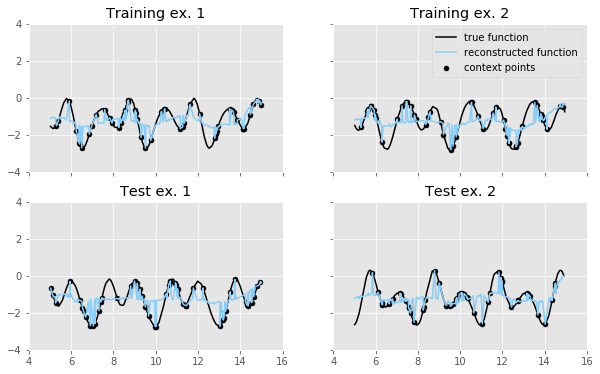

Epoch 5 batch 0 train Loss 0.2624 test Loss 0.2632 with training MSE metric 0.5257 and testing MSE metric 0.5273
learning rate is 9.999999747378752e-05


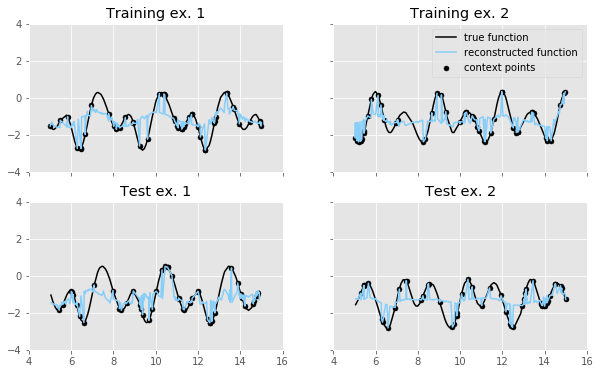

Epoch 5 batch 300 train Loss 0.2653 test Loss 0.2608 with training MSE metric 0.5316 and testing MSE metric 0.5222
learning rate is 9.999999747378752e-05


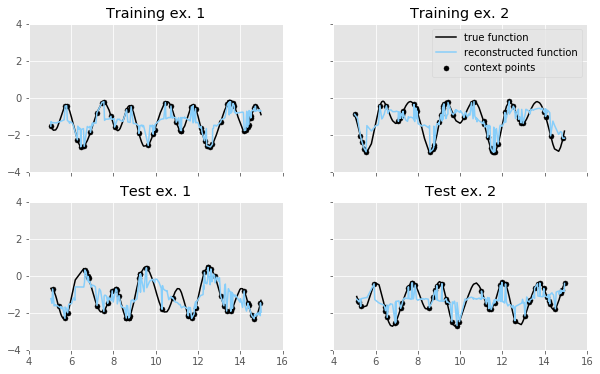

Epoch 5 batch 600 train Loss 0.2636 test Loss 0.2589 with training MSE metric 0.5281 and testing MSE metric 0.5179
learning rate is 9.999999747378752e-05


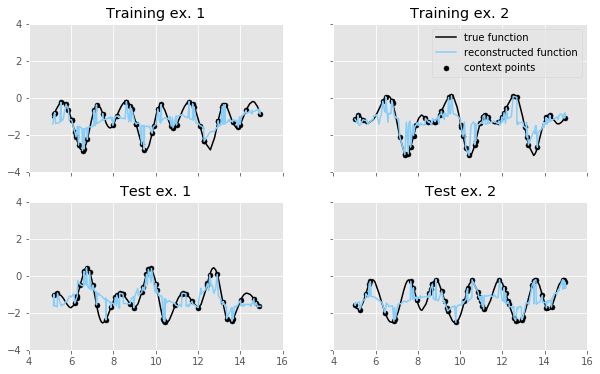

Epoch 5 batch 900 train Loss 0.2619 test Loss 0.2591 with training MSE metric 0.5246 and testing MSE metric 0.5185
learning rate is 9.999999747378752e-05


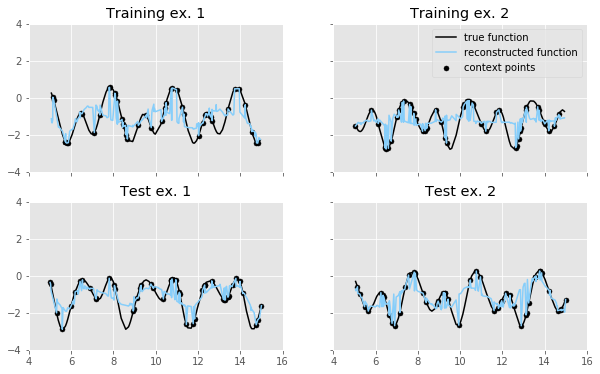

Epoch 5 batch 1200 train Loss 0.2604 test Loss 0.2572 with training MSE metric 0.5214 and testing MSE metric 0.5144
learning rate is 9.999999747378752e-05


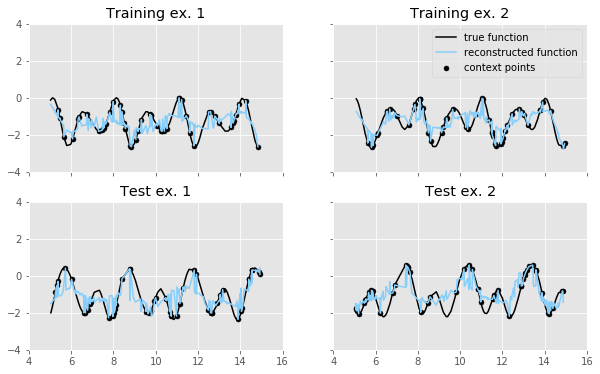

Epoch 5 batch 1500 train Loss 0.2587 test Loss 0.2555 with training MSE metric 0.5180 and testing MSE metric 0.5111
learning rate is 9.999999747378752e-05


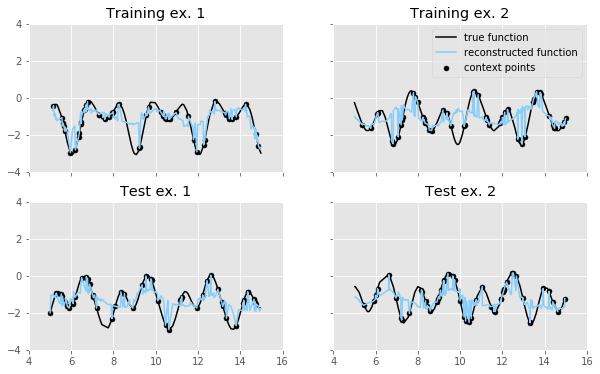

Epoch 5 batch 1800 train Loss 0.2574 test Loss 0.2549 with training MSE metric 0.5152 and testing MSE metric 0.5099
learning rate is 9.999999747378752e-05
Time taken for 1 epoch: 10241.524186849594 secs



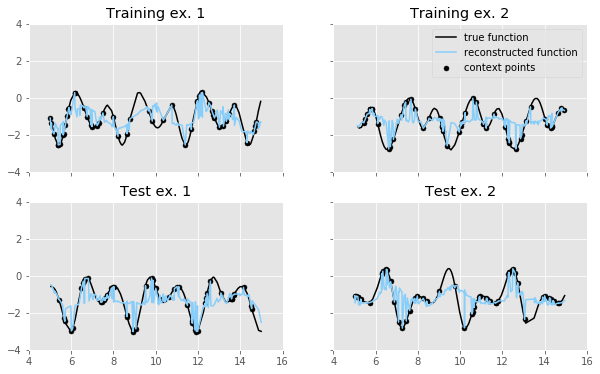

Epoch 6 batch 0 train Loss 0.2477 test Loss 0.2430 with training MSE metric 0.4956 and testing MSE metric 0.4865
learning rate is 9.999999747378752e-05


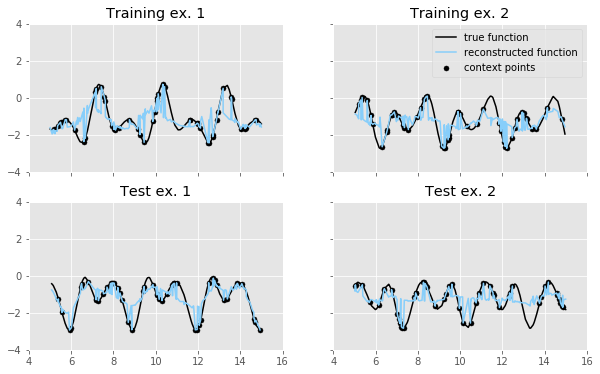

Epoch 6 batch 300 train Loss 0.2471 test Loss 0.2416 with training MSE metric 0.4944 and testing MSE metric 0.4837
learning rate is 9.999999747378752e-05


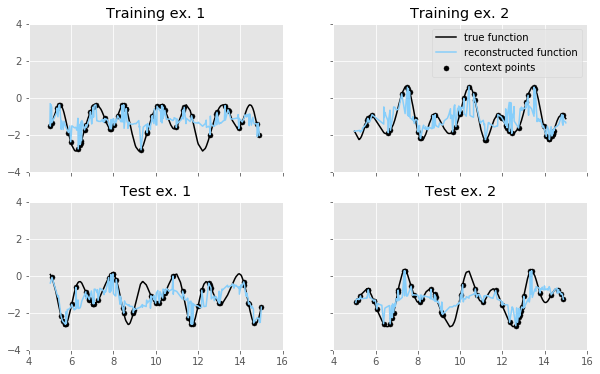

Epoch 6 batch 600 train Loss 0.2459 test Loss 0.2401 with training MSE metric 0.4920 and testing MSE metric 0.4807
learning rate is 9.999999747378752e-05


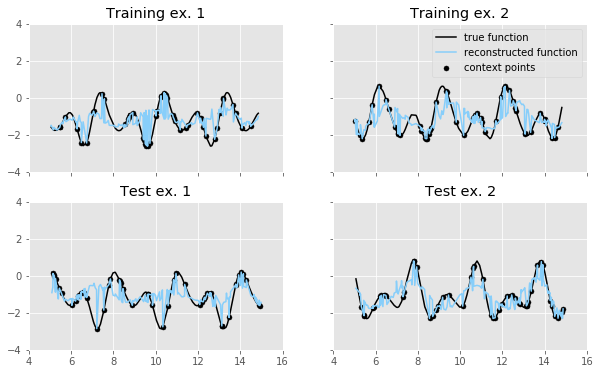

Epoch 6 batch 900 train Loss 0.2447 test Loss 0.2389 with training MSE metric 0.4896 and testing MSE metric 0.4784
learning rate is 9.999999747378752e-05


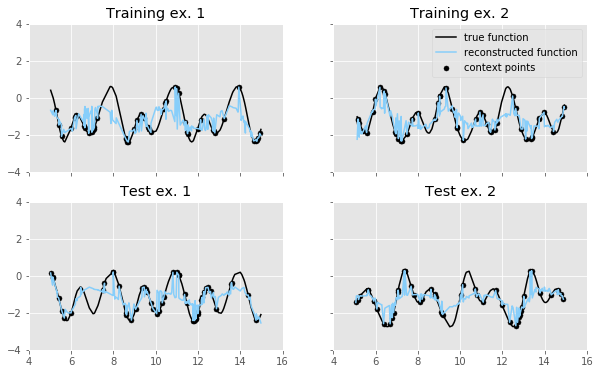

Epoch 6 batch 1200 train Loss 0.2434 test Loss 0.2377 with training MSE metric 0.4872 and testing MSE metric 0.4760
learning rate is 9.999999747378752e-05


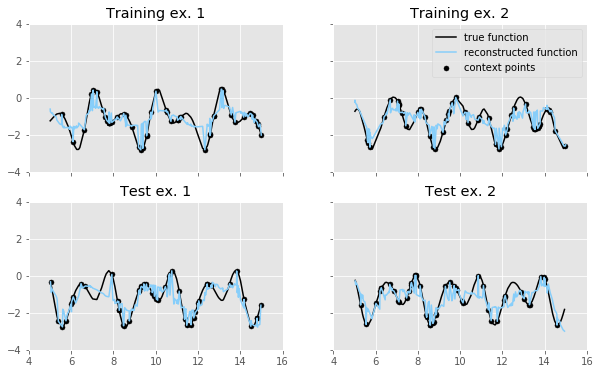

Epoch 6 batch 1500 train Loss 0.2423 test Loss 0.2373 with training MSE metric 0.4849 and testing MSE metric 0.4752
learning rate is 9.999999747378752e-05


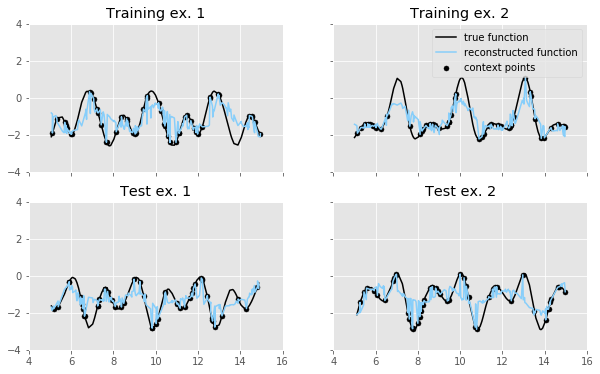

Epoch 6 batch 1800 train Loss 0.2414 test Loss 0.2363 with training MSE metric 0.4832 and testing MSE metric 0.4733
learning rate is 9.999999747378752e-05
Time taken for 1 epoch: 10639.30952501297 secs



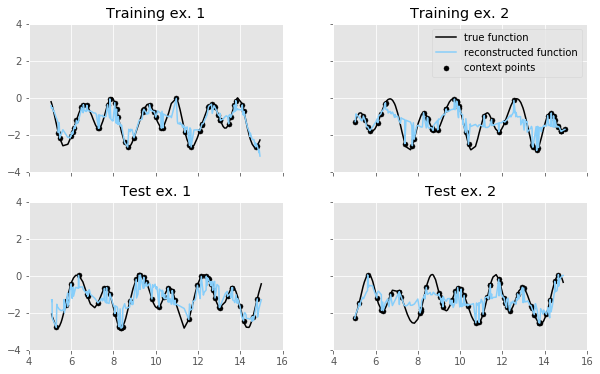

Epoch 7 batch 0 train Loss 0.2280 test Loss 0.2283 with training MSE metric 0.4571 and testing MSE metric 0.4581
learning rate is 9.999999747378752e-05


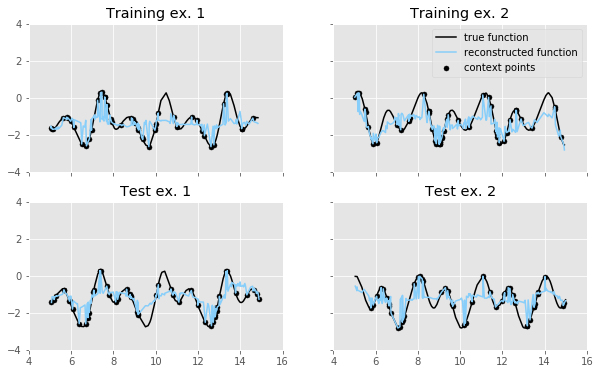

Epoch 7 batch 300 train Loss 0.2342 test Loss 0.2315 with training MSE metric 0.4693 and testing MSE metric 0.4638
learning rate is 9.999999747378752e-05


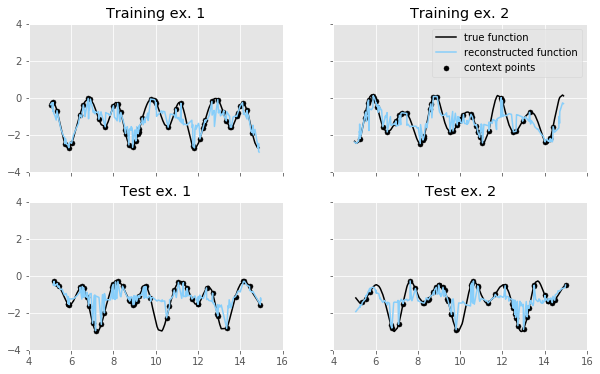

Epoch 7 batch 600 train Loss 0.2334 test Loss 0.2294 with training MSE metric 0.4679 and testing MSE metric 0.4601
learning rate is 9.999999747378752e-05


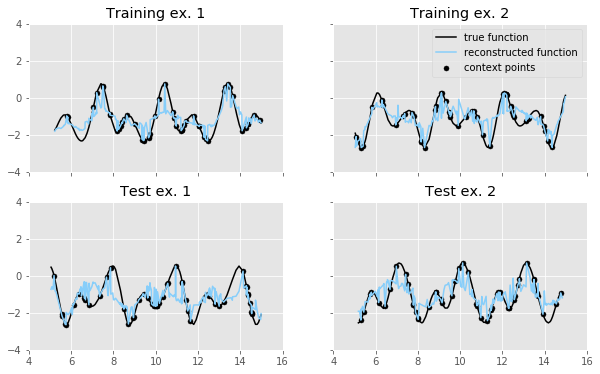

Epoch 7 batch 900 train Loss 0.2326 test Loss 0.2281 with training MSE metric 0.4665 and testing MSE metric 0.4579
learning rate is 9.999999747378752e-05


In [ ]:
if __name__ == '__main__':
    EPOCHS = 75; batch_s  = 64; run = 5; step = 0; train_steps = 35000; heads = 64; ℯ = 1024
    name_comp = '_run_' + str(run) #+ '_heads_' + str(heads) + '_encoding_' + str(ℯ)
    logdir = save_dir + '/logs/' + name_comp
    writer = tf.summary.create_file_writer(logdir)
    folder = save_dir + '/ckpt/check_' + name_comp; helpers.mkdir(folder)
    lr_fn = tf.optimizers.schedules.PolynomialDecay(9e-3, train_steps, 1e-7, 2)
    optimizer_c = tf.keras.optimizers.Adam(1e-4)
    \euler, heads, l1, l2, l3, l4 = helpers.load_spec(folder)
    decoder = experimental_model.Decoder(e = ℯ, l1, l2, l3, l4, num_heads = heads); tf.random.set_seed(443)   
    num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
#     num_batches = 1500
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
#     optimizer_c = tf.keras.optimizers.Adam(9e-3)
    with writer.as_default():
        for epoch in range(EPOCHS):
            m_tr.reset_states(); train_loss.reset_states()
            m_te.reset_states(); test_loss.reset_states()
            start = time.time()

            for batch_n in range(num_batches):

                batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
                pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr, batch_tar_tr)
                if ((epoch == 0) & (batch_n == 0)): helpers.write_speci(folder, names, shapes)
                if batch_n % 300 == 0:
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pad_pos_te[:500, :], pad_y_fren_te[:500, :])
                    plotter.follow_training_plot(batch_pos_tr, batch_tar_tr, pred, pad_pos_te[:500, :], pad_y_fren_te[:500, :], pred_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
#                     print('r squared training: ', 1 - m_tr.result() / (np.mean(np.mean((batch_tar_tr[:, 51:] - np.repeat(np.mean(batch_tar_tr, 1), 149).reshape(64, -1)) ** 2, 1))))
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
infer_plot(decoder, pad_pos_te, pad_y_fren_te, 150, np.array([7931]))